###Vocabulary overlap
just like in 'Don’t Stop Pretraining: Adapt Language Models to Domains and Tasks'. executed localy.

In [1]:
# code from https://github.com/allenai/dont-stop-pretraining slightly changed
from tqdm.notebook import tqdm
import json
from itertools import combinations
import seaborn as sns
import numpy as np
!pip install --upgrade matplotlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from glob import glob
from multiprocessing import Pool
import os
import re
import pandas as pd

print('Loading transformers lib...')
!pip install transformers
from transformers import AutoTokenizer

import sys
def i1():# helper function for fork printing
  sys.stdout.write(' ')
  sys.stdout.flush()

original_path = "/mnt/D21005A6100592A1/ΕΚΠΑ/πτυχιακή/Bert-final/"

Loading transformers lib...


In [2]:
# dump vocabularies to txt
print('Loading Greek-Bert tokenizer...')
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1",use_fast=True)
tokenizer.save_vocabulary(original_path+"datasets/")
os.rename(original_path+'datasets/vocab.txt', original_path+'datasets/Greek_Bert_vocab.txt')
# print('Loading Legal-Bert tokenizer...')
# tokenizer = AutoTokenizer.from_pretrained("",use_fast=True)
# tokenizer.save_vocabulary(original_path+"datasets/")
# os.rename(original_path+'datasets/vocab.txt', original_path+'datasets/Legal_Bert_vocab.txt')
print('Loading M-Bert tokenizer...')
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased",use_fast=True)
tokenizer.save_vocabulary(original_path+"datasets/")
os.rename(original_path+'datasets/vocab.txt', original_path+'datasets/M_Bert_vocab.txt')

Loading Greek-Bert tokenizer...
Loading M-Bert tokenizer...


In [3]:
def only_greek(vocab):
  """ findes greek words in vocab
  code from http://juditacs.github.io/2019/02/19/bert-tokenization-stats.html
  and https://github.com/juditacs/snippets/tree/master/deep_learning/bert_vocab_stats"""

  # from /unicode_ranges.txt
  # 0370	03FF	Greek/Coptic
  # 1F00	1FFF	Greek Extended
  unicode_ranges = {'Greek/Coptic': (int('0370',16),int('03FF',16)),
                    'Greek Extended': (int('1F00',16),int('1FFF',16))}

  def create_macro_regex(macro_range, include_digits=True):
      char_ranges = []
      for category in macro_range:
          start = unicode_ranges[category][0]
          end = unicode_ranges[category][1]
          char_ranges.append(r'\U{0:08x}-\U{1:08x}'.format(start, end))
      if include_digits:
          return re.compile(r'^(##)?([{0}]+[\d{0}]*)|([\d{0}]*[{0}]+)$'.format(''.join(char_ranges)))
      return re.compile(r'^(##)?[{}]+$'.format(''.join(char_ranges)))

  ans = pd.Series(vocab).str.match(create_macro_regex(['Greek/Coptic', 'Greek Extended']))
  new = [vocab[i] for i, a in enumerate(ans) if a == True]
  return new

def load_vocab(directory):
  """ loads vocabulary """
  vocab = []
  with open(directory) as f:
    for line in f:
      vocab.append(line)
  print(f'{directory[-20:]} vocab size {len(vocab)}')
  if 'M_Bert' in directory:
    vocab = only_greek(vocab)
    print(f'{directory[-20:]} Greek vocab size {len(vocab)}')
  return (directory, set(vocab))

In [4]:
files = glob(original_path+"datasets/*.txt")

with Pool(processes=3, initializer=i1) as pool:
  results = list(tqdm(pool.imap(load_vocab, files), total=len(files),
               desc='making vocabularies', leave=True))
vocabs = {}
for res in results:
  if 'Greek_Bert' in res[0]:
    key = 'Greek-Bert'
  elif 'Legal_Bert' in res[0]:
    key = 'Legal-Bert'
  elif 'M_Bert' in res[0]:
    key = 'M-Bert'
  vocabs[key] = res[1]
file_pairs = combinations(list(vocabs.keys()), 2)

overlaps = {}
for x, y in file_pairs:
  intersection = vocabs[x] & vocabs[y]
  union = (vocabs[x] | vocabs[y])
  # print(len(intersection) , len(union))
  overlaps[x + "_" + y] = len(intersection) / len(union)

# print("saving overlaps...")
# with open(original_path+"dont_stop_pretraining/vocab_overlaps.json", "w+") as f:
#   json.dump(overlaps, f)

   Greek_Bert_vocab.txt vocab size 35000
ets/M_Bert_vocab.txt vocab size 105879
Legal_Bert_vocab.txt vocab size 35100


ets/M_Bert_vocab.txt Greek vocab size 1214



findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


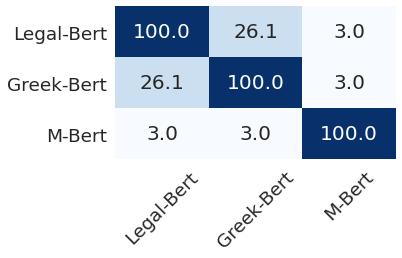

In [5]:
sns.set(context="paper", style="white", font_scale=2.1, font="Times New Roman")

z = {}
for key in overlaps.keys():
  file_1, file_2 = key.split('_')
  if not z.get(file_1):
    z[file_1] = {}
  z[file_1][file_2] = overlaps[key]
  if not z.get(file_2):
    z[file_2] = {}
  z[file_2][file_1] = overlaps[key]
labels = ["Legal-Bert", "Greek-Bert", "M-Bert"]
data = []
for ix, key in enumerate(labels):
  items = []
  for subkey in labels:
    if not z[key].get(subkey):
      items.append(1.0)
    else:
      items.append(z[key][subkey])
  data.append(items)
data = np.array(data) * 100
ax = sns.heatmap(data, cmap="Blues", vmin=5, xticklabels=labels,
                 annot=True, fmt=".1f", cbar=False, yticklabels=labels)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.tight_layout()